# Experiments with GloVE embeddings

To get data:

1. Run `python scripts/download_glove.py`
2. Wait for it...
3. Proceed.

In [15]:
import graph_structure as gs
import numpy as np
from tqdm import tqdm
from joblib import Parallel,delayed
import matplotlib.pyplot as plt
import scipy.stats as st
from sklearn.metrics import pairwise_distances
import pandas as pd
import re

## Reading data files

In [16]:
with open('../data/questions-words.txt', 'r') as f:
    data = f.read()
print(len(data))

603955


In [17]:
# Reading analogies
titles = re.findall(':.*\n', data)
contents = re.split(':.*\n', data)

metaphors = {}
for idx, s in enumerate(titles):
    title = s.replace('\n', '').replace(': ', '').rstrip().lstrip()
    lines = contents[idx+1].split('\n')
    g1 = []
    g2 = []
    for line in lines:
        if len(line) < 5:
            continue
        #print(line)
        a, b, c, d = line.split(' ')
        if (a not in g1) and (b not in g2):
            g1.append(a)
            g2.append(b)
        if (c not in g1) and (d not in g2):
            g1.append(c)
            g2.append(d)
    metaphors[title] = [g1, g2]

In [18]:
# Load GloVe embeddings
fnames = ['glove.6B.50d.txt','glove.6B.100d.txt','glove.6B.200d.txt','glove.6B.300d.txt']
def load_glove(fname):
    embed_dict = {}
    with open('../data/' + fname,'r') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:],'float32')
            embed_dict[word]=vector
    return embed_dict

In [19]:
def embedding_space(word_list, embed_dict):
    x = [embed_dict[w.lower()] for w in word_list]
    x = np.array(x)
    return x

In [20]:
def topology_experiment(metaphors, embed_dict, k):
    results = {}
    for category in metaphors.keys():
        g1 = metaphors[category][0]
        g2 = metaphors[category][1]
        e1 = embedding_space(g1, embed_dict)
        e2 = embedding_space(g2, embed_dict)
        if type(k)==float:
            k_ = int(k*len(metaphors[category][0]))
        else:
            k_ = k
        a = gs.mean_neighborhood_similarity_from_points(e1, e2, k_)
        results[category] = (a, len(g1))
    return results

## Topology vs. K


In [21]:
fname = fnames[0]
embed_dict = load_glove(fname)
print("Loaded")


Loaded


In [22]:

sg = {}

for category in tqdm(metaphors.keys()):
    sg[category] = []
    g1 = np.array(metaphors[category][0])
    g2 = np.array(metaphors[category][1])
    

    #print(choices, n_bootstrap,e1.shape, len(g1))
    e1 = embedding_space(g1, embed_dict)
    e2 = embedding_space(g2, embed_dict)
    
    ks = list(range(1, len(e1)))        
    for idx, k in enumerate(ks):
        s = gs.mean_neighborhood_similarity_from_points(e1, e2, k)
        sg[category].append(s)
    
    sg[category] = np.array(sg[category])
    

100%|██████████| 14/14 [00:00<00:00, 14.37it/s]


In [23]:
M = 1000
n = np.array(list(range(2,M)))
N = n
intersection = st.hypergeom.mean(M,n,N)
union = 2 * np.array(n) - np.array(intersection)
js = intersection/union

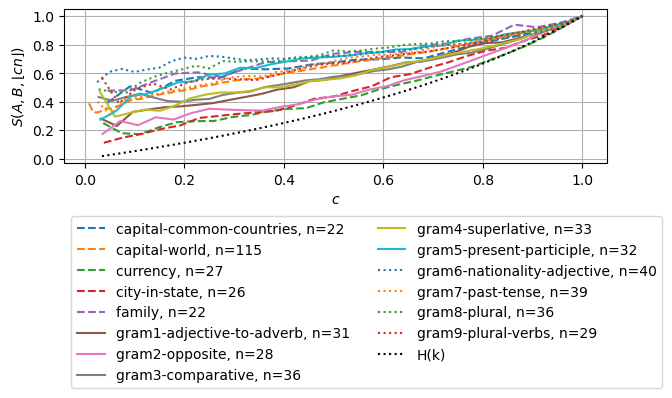

In [31]:

plt.figure(figsize=(7,2))
styles = ['--'] * 5 + ['-'] * 5 + [':'] * 5
for idx, category in enumerate(sg.keys()):
    ks = np.array(list(range(1, len(sg[category])+1)))
    xaxis = ks/ks[-1]
    plt.plot(xaxis, sg[category], label=f'{category}, n={len(sg[category])}', linestyle=styles[idx])
    #plt.fill_between(xaxis, sg[category]+2*sg_dv[category], sg[category]-2*sg_dv[category], alpha=0.5)
    
    #plt.plot(ks, sg[category],  label=f'{category}', linestyle=styles[idx])

plt.plot(n/len(n), js, 'k:', label='H(k)')    
plt.legend(ncols=2, loc='upper left', bbox_to_anchor=(0.0, -0.3))
plt.xlabel('$c$')
plt.ylabel('$S(A,B,\lfloor cn \\rfloor)$')
a = 0.2
plt.yticks(np.arange(0,1+a, a))
plt.grid()
plt.savefig('glove_similarity.pdf', bbox_inches='tight')
plt.show()

/home/tiago/miniconda3/envs/graph/lib/python3.11/site-packages/scipy/stats/_discrete_distns.py:654: RuntimeWarning: divide by zero encountered in divide
  g2 /= n * N * (M - N) * m * (M - 2.) * (M - 3.)
/home/tiago/miniconda3/envs/graph/lib/python3.11/site-packages/scipy/stats/_discrete_distns.py:658: RuntimeWarning: divide by zero encountered in _hypergeom_skewness
  _boost._hypergeom_skewness(n, N, M),
/tmp/ipykernel_3577081/1474188258.py:12: RuntimeWarning: invalid value encountered in divide
  yaxis = (np.array(sg[category])-np.array(js))/(1-np.array(js))


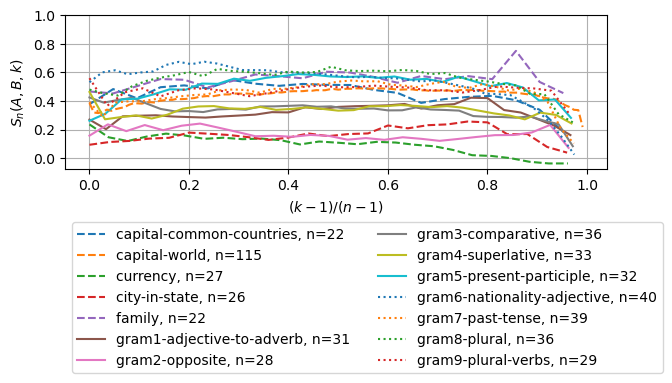

In [25]:
plt.figure(figsize=(7,2))
styles = ['--'] * 5 + ['-'] * 5 + [':'] * 5
for idx, category in enumerate(sg.keys()):
    ks = np.array(list(range(1, len(sg[category])+1)))
    M = len(ks)
    n = ks
    N = n
    intersection = st.hypergeom.mean(M,n,N)
    union = 2 * np.array(n) - np.array(intersection)
    js = np.array(intersection/union)  
    xaxis = (ks-1)/(len(ks)-1)
    yaxis = (np.array(sg[category])-np.array(js))/(1-np.array(js))
    plt.plot(xaxis, yaxis, label=f'{category}, n={len(sg[category])}', linestyle=styles[idx])
    #plt.fill_between(xaxis, sg[category]+2*sg_dv[category], sg[category]-2*sg_dv[category], alpha=0.5)
    
    #plt.plot(ks, sg[category],  label=f'{category}', linestyle=styles[idx])

#plt.plot(n/len(n), js, 'k:', label='Hypergeometric')    
plt.legend(ncols=2, loc='upper left', bbox_to_anchor=(0.0, -0.3))
plt.xlabel('$(k-1)/(n-1)$')
plt.ylabel('$S_n(A,B,k)$')
a = 0.2
plt.yticks(np.arange(0,1+a, a))
plt.grid()
plt.show()

In [26]:

def analogy_experiment(metaphors, embed_dict):
    results = {}
    for category in metaphors.keys():
        g1 = metaphors[category][0]
        g2 = metaphors[category][1]
        e1 = embedding_space(g1, embed_dict)
        e2 = embedding_space(g2, embed_dict)

        acc = 0
        tries = 0        
        for i in range(len(g1)):
            for j in range(i+1, len(g1)):
                tries += 1
                w = e1[i,:] - e2[i,:] + e1[j,:]
                w = w.reshape( (1,-1))
                p = pairwise_distances(w, e2, metric='cosine')
                if np.argmin(p)==j:
                    acc += 1
        
        results[category] = (acc/tries, len(g1))
    return results

In [32]:
res = {}
res2 = {}
for fname in [fnames[-1]]:
    print(fname)
    embed_dict = load_glove(fname)
    res[fname] = topology_experiment(metaphors, embed_dict, 0.2)
    res2[fname] = analogy_experiment(metaphors, embed_dict)

glove.6B.300d.txt


In [34]:
categories = res[fname].keys()

r1, r2, c = [], [], []
for cat in categories:
    r1 = r1 + [res[f][cat][0] for f in [fnames[-1]]]
    r2 = r2 + [res2[f][cat][0] for f in [fnames[-1]]]
    c = c + fnames
st.pearsonr(r1, r2)

PearsonRResult(statistic=0.938088573014564, pvalue=7.10868974545754e-07)

In [38]:
# categories = list(res[fnames[-1]].keys())
# for i in range(len(r1)//4):
#     r1_ = r1[i*4:(i+1)*4]
#     r2_ = r2[i*4:(i+1)*4]
    
#     print(categories[i], st.pearsonr(r1_, r2_))

capital-common-countries PearsonRResult(statistic=0.9859468753970595, pvalue=0.014053124602940503)
capital-world PearsonRResult(statistic=0.9389878678275678, pvalue=0.061012132172432176)
currency PearsonRResult(statistic=0.8906915547900298, pvalue=0.10930844520997018)


In [ ]:
df = pd.DataFrame()
df['topology'] = r1
df['analogy'] = r2
df['files'] = ['_'.join(c_.split('.')[:-1]) for c_ in c]
df.head()

,topology,analogy,files
0,0.546170,0.837945,glove_6B_50d
1,0.527950,0.956522,glove_6B_100d
2,0.522981,0.996047,glove_6B_200d
3,0.571014,0.996047,glove_6B_300d
4,0.478888,0.535082,glove_6B_50d


In [ ]:
for i in range(4):
    s= df.iloc[i::4][['topology', 'analogy']]
    print(df.iloc[i]['files'])
    print(s.corr())

glove_6B_50d
          topology   analogy
topology  1.000000  0.896465
analogy   0.896465  1.000000
glove_6B_100d
          topology   analogy
topology  1.000000  0.878259
analogy   0.878259  1.000000
glove_6B_200d
          topology   analogy
topology  1.000000  0.915063
analogy   0.915063  1.000000
glove_6B_300d
          topology   analogy
topology  1.000000  0.938089
analogy   0.938089  1.000000


In [ ]:
colors = ['r', 'g', 'b', 'k']
legends = ['50d', '100d', '200d', '300d']

plt.figure()
for j in range(4):
    if j == 1 or j ==2 or j==1:
        continue
    plt.scatter(df.iloc[j::4]['topology'], df.iloc[j::4]['analogy'], c=colors[j], label=legends[j])

styles = ['--'] * 5 + ['-'] * 5 + [':'] * 5
for i in range(14):
    x = df['topology'][i*4:i*4+4]
    y = df['analogy'][i*4:i*4+4]
    plt.plot(x.iloc[[0, 3]], y.iloc[[0, 3]], label=f'{categories[i]}, n={len(metaphors[categories[i]][0])}', linestyle=styles[i])
    #plt.plot(x, y, label=categories[i], linestyle=styles[i])
plt.xlabel('$S(A,B,k)$')
plt.ylabel('Analogy accuracy')
#plt.xlim([0.2,.6])
plt.ylim([0,1])
plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left')
#plt.title('GLoVe embeddings and Structural distance')
plt.savefig('glove_accuracy_similarity.pdf', bbox_inches='tight')
plt.show()

NameError: name 'plt' is not defined